In [1]:
%matplotlib widget

import ipywidgets as widgets
from ipywidgets import HBox, VBox, jslink, Box, Layout
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from IPython.display import display, Image, Math
from scipy.integrate import solve_ivp
from scipy.signal import place_poles
import control.matlab as control

In [2]:
def make_box_layout():
     return widgets.Layout(
        border='solid 1px black',
        margin='0px 5px 5px 0px',
        padding='2px 2px 2px 2px'
     )

## Lineares LTI System 2. Ordnung

\begin{align*}
    \dot{\boldsymbol{x}}(t) &= \begin{pmatrix}
		0 & 1 \\ -3 & -4
	\end{pmatrix} \, \boldsymbol{x}(t) + \begin{pmatrix}
	0 \\ 3 
\end{pmatrix} \, \boldsymbol{u}(t) \\
     y(t) &= \begin{pmatrix} 1 & 0 \end{pmatrix} \, \boldsymbol{x}(t)
\end{align*}

## Simulationsparameter

In [30]:
tSim = np.linspace(0, 3, 301)
x0 = [3, 1, 2, 0]
A = np.array([[0, 1], [-3, -4]])
b = np.array([[0], [3]])
c = np.array([[1], [0]])

## Lineares System mit Zustandsregler ohne Vorfilter

In [155]:
def linSystemStateCont(t, x, A, b, c, k, l):

    xBeob = x[0:2]
    xSys = x[2::]

    u = -k @ xBeob

    dxBeob = A @ xBeob + b @ u - l.T * c.T @ (xBeob - xSys)
    dxSys = A @ xSys + b @ u

    return np.concatenate([dxBeob, dxSys])

## Analyse Eigenwerte

In [156]:
eigA = np.linalg.eig(A)[0]
Math(r's_1 = ' + str(eigA[0]) + r',~s_2 = ' + str(eigA[1]))

<IPython.core.display.Math object>

## Überprüfen Steuerbarkeit

In [157]:
S = control.ctrb(A, b)
Math(r'S = ' + sp.latex(sp.Matrix(S)))

<IPython.core.display.Math object>

In [158]:
rank = np.linalg.matrix_rank(S)
Math(r'\mathrm{rang}(\mathcal{S}) = ' + str(rank)) 

<IPython.core.display.Math object>

## Reglerentwurf

In [159]:
poles = np.array([-3, -6])
pp = place_poles(A, b, poles)
k = pp.gain_matrix[0].reshape((1,2))
Math(r'\boldsymbol{k}=' + sp.latex(sp.Matrix(k)))

<IPython.core.display.Math object>

### Kontrolle

In [160]:
np.linalg.eig(A - b @ k)[0]

array([-3., -6.])

## Überprüfen Beobachtbarkeit

In [161]:
O = control.obsv(A, c.T)
Math(r'O = ' + sp.latex(sp.Matrix(O)))

<IPython.core.display.Math object>

In [162]:
rank = np.linalg.matrix_rank(S)
Math(r'\mathrm{rang}(\mathcal{O}) = ' + str(rank)) 

<IPython.core.display.Math object>

## Beobachterentwurf

In [165]:
poles = np.array([-15, -20])
pp = place_poles(A.T, c, poles)
l = pp.gain_matrix[0].reshape((1,2))
Math(r'\boldsymbol{l}=' + sp.latex(sp.Matrix(l)))

<IPython.core.display.Math object>

### Kontrolle

In [166]:
np.linalg.eig(A - l.T @ c.T)[0]

array([-20., -15.])

## Simulation

In [167]:
res = solve_ivp(linSystemStateCont, [tSim[0], tSim[-1]], x0,
                       t_eval=tSim, args=(A, b, c, k, l))

Text(0, 0.5, 'y(t)')

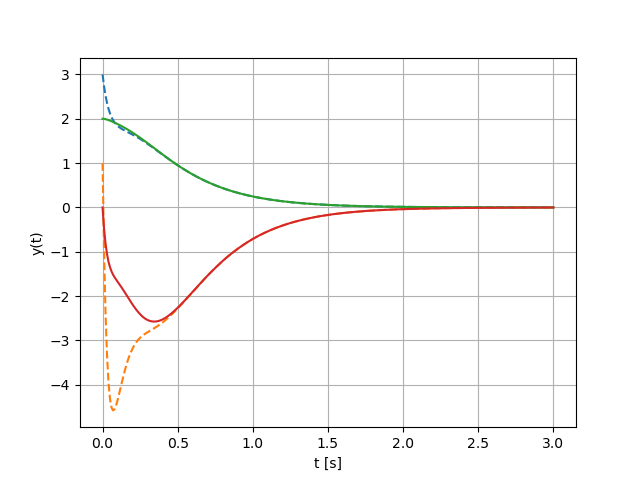

In [168]:
plt.figure()
plt.plot(res.t, res.y[0, :], '--')
plt.plot(res.t, res.y[1, :], '--')
plt.plot(res.t, res.y[2, :])
plt.plot(res.t, res.y[3, :])
plt.grid()
plt.xlabel('t [s]')
plt.ylabel('y(t)')

## Lineares System mit Zustandsregler mit Vorfilter und Beobachter

In [169]:
def linSystemStateContFactor(t, x, yRef, A, b, c, k, l):

    xBeob = x[0:2]
    xSys = x[2::]
    V = 1 / (c.T @ np.linalg.inv(b @ k - A) @ b)

    u = V[0] * yRef - k @ xSys

    dxBeob = A @ xBeob + b @ u - l.T * c.T @ (xBeob - xSys)
    dxSys = A @ xSys + b @ u

    return np.concatenate([dxBeob, dxSys])

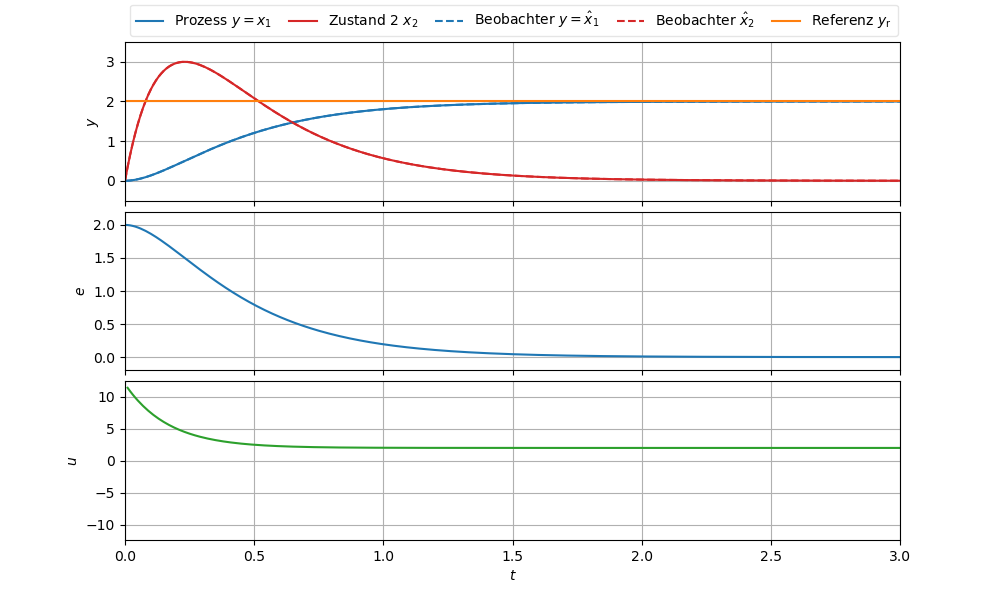

In [173]:
output = widgets.Output()

with output:
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(10, 6), sharex=True, gridspec_kw={'height_ratios': [1, 1, 1]})

plt.subplots_adjust(wspace=0.2, hspace=0.07)
fig.canvas.toolbar_visible = False
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
fig.subplots_adjust(bottom=0.1, top=0.93, left=0.125, right=0.9)

ax1.set_xlim([0, tSim[-1]])
ax2.set_xlim([0, tSim[-1]])
ax3.set_xlim([0, tSim[-1]])
ax1.set_ylim([-0.05, 3.55])
ax2.set_ylim([-2, 2])
ax3.set_ylim([-2, 2])
ax1.grid()
ax2.grid()
ax3.grid()
ax1.set_ylabel(r"$y$")
ax2.set_ylabel(r"$e$")
ax3.set_ylabel(r"$u$")
ax3.set_xlabel(r"$t$")

ySys, = ax1.plot([], [], 'C0', label=r'Prozess $y = x_1$')
x2Sys, = ax1.plot([], [], 'C3', label=r'Zustand 2 $x_2$')
yObs, = ax1.plot([], [], 'C0', linestyle='dashed', label=r'Beobachter $y = \hat{x}_1$')
x2Obs, = ax1.plot([], [], 'C3', linestyle='dashed', label=r'Beobachter $\hat{x}_2$')
yRefSys, = ax1.plot([], [], 'C1', label=r'Referenz $y_\mathrm{r}$')
eSys, = ax2.plot([], [], 'C0', label=r'Fehler $e$')
uFBSys, = ax3.plot([], [], 'C2', label=r'Regler $u$')

handlesAx, labelsAx = ax1.get_legend_handles_labels()

fig.legend([handle for i, handle in enumerate(handlesAx)],
           [label for i, label in enumerate(labelsAx)],
           bbox_to_anchor=(0.13, 0.94, 0.7675, .15), loc=3,
           ncol=6, mode="expand", borderaxespad=0., framealpha=0.5)

sliderYr = widgets.FloatSlider(value=2,
                               min=0,
                               max=5,
                               step=0.5,
                               description=r'$y_{\mathrm{r}}$')
sliderEig1 = widgets.FloatSlider(value=-3,
                               min=-20,
                               max=-0.01,
                               step=0.1,
                               description=r'$s_1$')
sliderEig2 = widgets.FloatSlider(value=-6,
                               min=-20,
                               max=-0.01,
                               step=0.1,
                               description=r'$s_2$')
sliderEigObs1 = widgets.FloatSlider(value=-3,
                               min=-20,
                               max=-0.01,
                               step=0.1,
                               description=r'$\hat{s}_1$')
sliderEigObs2 = widgets.FloatSlider(value=-6,
                               min=-20,
                               max=-0.01,
                               step=0.1,
                               description=r'$\hat{s}_2$')
sliderX01 = widgets.FloatSlider(value=0,
                               min=-10,
                               max=10,
                               step=0.1,
                               description=r'$x_1(0)$')
sliderX02 = widgets.FloatSlider(value=0,
                               min=-10,
                               max=10,
                               step=0.1,
                               description=r'$x_2(0)$')
sliderX01Obs = widgets.FloatSlider(value=0,
                               min=-10,
                               max=10,
                               step=0.1,
                               description=r'$\hat{x}_1(0)$')
sliderX02Obs = widgets.FloatSlider(value=0,
                               min=-10,
                               max=10,
                               step=0.1,
                               description=r'$\hat{x}_2(0)$')

def calcSystem(_):
    yr = sliderYr.value
    
    pp = place_poles(A, b, np.array([sliderEig1.value, sliderEig2.value]))
    k = pp.gain_matrix[0].reshape((1,2))
    
    pp = place_poles(A.T, c, np.array([sliderEigObs1.value, sliderEigObs2.value]))
    l = pp.gain_matrix[0].reshape((1,2))
    
    x0 = [sliderX01Obs.value, sliderX02Obs.value, sliderX01.value, sliderX02.value]
    res = solve_ivp(linSystemStateContFactor,
                    [tSim[0], tSim[-1]],
                    x0,
                    t_eval=tSim, args=(yr, A, b, c, k, l))
    
    V = 1 / (c.T @ np.linalg.inv(b @ k - A) @ b)
           
    sigFB = [V * yr - k @ res.y.T[idx + 1, 0:2] for idx, t in enumerate(tSim[1:])]
    sigE = yr - res.y.T[:, 0]
    uFBSys.set_data(tSim[1:], sigFB)
    ySys.set_data(tSim, res.y.T[:, 2])
    x2Sys.set_data(tSim, res.y.T[:, 3])
    yObs.set_data(tSim, res.y.T[:, 0])
    x2Obs.set_data(tSim, res.y.T[:, 1])
    yRefSys.set_data(tSim[[0, -1]], np.array([yr, yr]))
    eSys.set_data(tSim, sigE)
    
    uMax = np.max(sigFB)
    ax1.set_ylim(np.min(res.y) - 0.5, np.max(res.y) + 0.5)
    ax2.set_ylim([(np.min(sigE) - 0.2), (np.max(sigE) + 0.2)]) 
    ax3.set_ylim([-(uMax + 1), (uMax + 1)]) 
    
    fig.canvas.draw()

sliderYr.observe(calcSystem, names='value')
sliderEig1.observe(calcSystem, names='value')
sliderEig2.observe(calcSystem, names='value')
sliderEigObs1.observe(calcSystem, names='value')
sliderEigObs2.observe(calcSystem, names='value')
sliderX01.observe(calcSystem, names='value')
sliderX02.observe(calcSystem, names='value')
sliderX01Obs.observe(calcSystem, names='value')
sliderX02Obs.observe(calcSystem, names='value')

calcSystem(_)

stateContControls = VBox([sliderYr, sliderEig1, sliderEig2])
stateContControls.layout = make_box_layout()
obsControls = VBox([sliderEigObs1, sliderEigObs2, sliderX01Obs, sliderX02Obs])
obsControls.layout = make_box_layout()
sysControls = VBox([sliderX01, sliderX02])
sysControls.layout = make_box_layout()


controls = HBox([sysControls, stateContControls, obsControls])
VBox([controls, output], layout=Layout(display='flex', flex_flow='row', justify_content='center', align_items='center'))